# Figure 6C: Plot position displacement.

We plot the relationship between position displacement between a boid and flock and its subsequent velocity(t+1).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as functional
from torch.utils.data import random_split
from torch_geometric.data import Batch, Data, DataLoader

In [17]:
import os
import sys

script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env/gnn")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")
sys.path.append("/workspace/collab-environment/figures")

In [18]:
from collab_env.data.file_utils import expand_path, get_project_root

In [21]:
from collab_env.data.boids.animal_simulation import visualize_graph, visualize_pair
from collab_env.gnn.gnn import (get_adjcency_from_debug, plot_log_loss, train_rules_gnn,
    identify_frames, find_frame_sets, load_model, debug_result2prediction)
from utility import handle_discrete_data
from collab_env.gnn.gnn_definition import GNN, Lazy
from collab_env.data.boids.animal_simulation import visualize_graph_2sets
from figures.gnn.plot_helpers import (rollout_to_pos_vel_acc,
    data_to_pos_vel_acc,
    return_deltapos_vnext,
    figure_data_C)


## Data

#### a) without food

In [9]:
# without food
data_name = 'boid_single_species_basic'
file_name = f'{data_name}.pt'
config_name = f'{data_name}_config.pt'

dataset = torch.load(expand_path(
        "simulated_data/" + file_name, get_project_root()), weights_only = False)
species_configs = torch.load(expand_path(
        "simulated_data/" + config_name, get_project_root()), weights_only = False)

data_name2 = 'boid_single_species_independent'
file_name2 = f'{data_name2}.pt'
config_name2 = f'{data_name2}_config.pt'

dataset2 = torch.load(expand_path(
        "simulated_data/" + file_name2, get_project_root()), weights_only = False)
species_configs2 = torch.load(expand_path(
        "simulated_data/" + config_name2, get_project_root()), weights_only = False)

#### b) with food

In [45]:
# with food
data_name = 'boid_food_basic_alignment'
file_name = f'{data_name}.pt'
config_name = f'{data_name}_config.pt'

dataset = torch.load(expand_path(
        "simulated_data/" + file_name, get_project_root()), weights_only = False)
species_configs = torch.load(expand_path(
        "simulated_data/" + config_name, get_project_root()), weights_only = False)

data_name2 = 'boid_food_basic_independent'
file_name2 = f'{data_name2}.pt'
config_name2 = f'{data_name2}_config.pt'

dataset2 = torch.load(expand_path(
        "simulated_data/" + file_name2, get_project_root()), weights_only = False)
species_configs2 = torch.load(expand_path(
        "simulated_data/" + config_name2, get_project_root()), weights_only = False)

In [79]:
del_pos, vnext = figure_data_C(test_loader, None, starting_frame = 5, ending_frame = 500)
#location, data, sd = mean_traces(del_pos, vnext)

del_pos2, vnext2 = figure_data_C(test_loader2, None, starting_frame = 5, ending_frame = 500)
#location2, data2, sd2 = mean_traces(del_pos2, vnext2)
#bins, mean, sd = mean_traces(del_v, acc_)


Text(0.5, 1.0, 'Food, independent')

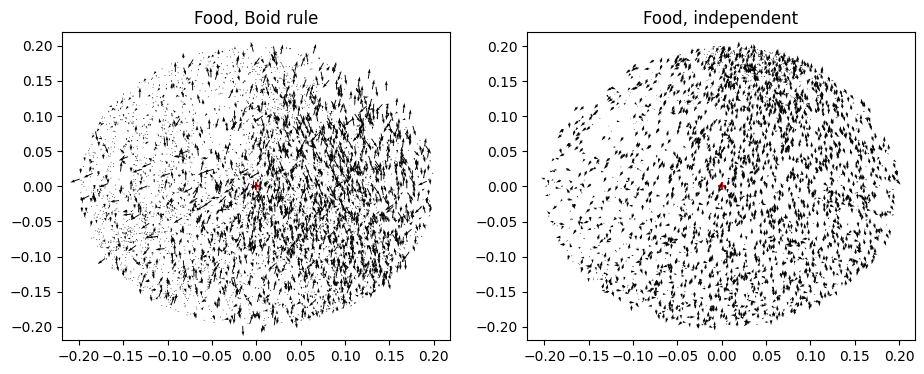

In [80]:
fig, axes = plt.subplots(1, 2, figsize = (11, 4))

axes[0].scatter(0,0,marker = '+',c = 'r')
axes[0].quiver(del_pos[:,0],del_pos[:,1],
            vnext[:,0]*10,vnext[:,1]*10)


axes[1].scatter(0,0,marker = '+',c = 'r')
axes[1].quiver(del_pos2[:,0],del_pos2[:,1],
            vnext2[:,0]*10,vnext2[:,1]*10)

axes[0].set_title("Food, Boid rule")
axes[1].set_title("Food, independent")


## Load models

In [50]:
# split data into training set and test set
test_size = int(len(dataset) / 2)
train_size = len(dataset) - test_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(2025)
)

# split data into training set and test set
test_size2 = int(len(dataset2) / 2)
train_size2 = len(dataset2) - test_size2

train_dataset2, test_dataset2 = random_split(
    dataset2, [train_size2, test_size2], generator=torch.Generator().manual_seed(2025)
)

# create mini-batches
batch_size = 1
# right now we assume the batch_size = 1, because our real dataset are of different lengths.
# But we can expand to minibatches - except fpr a few specific functions, every function is written with minibatches in mind.
test_loader = DataLoader(test_dataset,
                         batch_size = batch_size, shuffle=False)

test_loader2 = DataLoader(test_dataset2,
                         batch_size = batch_size, shuffle=False)

In [55]:
pos, species = list(test_loader)[0]

In [51]:
# load model
models = {}
model_spec = {}
train_spec = {}

for m in ["vpluspplus_a", "lazy"]:
    file_name = f"{data_name}_{m}_noise_{0}"
    models[m] = {}
    models[m]["model"], model_spec[m], train_spec[m] = load_model(m, file_name)
   

Loaded model spec.
Loaded training spec.
Loaded model.
Loaded model spec.
Loaded training spec.
Loaded lazy model.


In [57]:
# do rollout
rollout = 5
torch.cuda.empty_cache()

for m in ["vpluspplus_a"]:
    
    gnn_model = models[m]["model"]
    gnn_training_spec = train_spec[m]

    gnn_training_spec["training"] = False
    gnn_training_spec["lr"] = None
    gnn_training_spec["rollout"] = rollout

    # train models
    (models[m]["rollout_losses"], _, models[m]["rollout_debug_result"]) = train_rules_gnn(
        gnn_model,
        test_loader,
        species_dim=len(torch.unique(species)),
        **gnn_training_spec
    )

    models[m]["rollout_W_input"], models[m]["rollout_W_output"] = get_adjcency_from_debug(
        models[m]["rollout_debug_result"], test_loader, gnn_training_spec["visual_range"])

epoch 0


batch 0




/workspace/collab-environment/collab_env/gnn/gnn.py:380: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(pos)
/workspace/collab-environment/collab_env/gnn/gnn.py:381: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vel = torch.tensor(vel)
/workspace/collab-environment/collab_env/gnn/gnn.py:382: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc = torch.tensor(acc)
/workspace/collab-environment/collab_env/gnn/gnn.py:443: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or so

batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 0.0015
finished one epoch


In [64]:
# load model
for m in ["vpluspplus_a", "lazy"]:
    new_name = m + "independent"
    file_name = f"{data_name2}_{m}_noise_{0}"
    
    models[new_name] = {}
    models[new_name]["model"], model_spec[new_name], train_spec[new_name] = load_model(m, file_name)
   

Loaded model spec.
Loaded training spec.
Loaded model.
Loaded model spec.
Loaded training spec.
Loaded lazy model.


In [65]:
# do rollout
rollout = 5
torch.cuda.empty_cache()

for m in ["vpluspplus_a" + "independent"]:
    
    gnn_model = models[m]["model"]
    gnn_training_spec = train_spec[m]

    gnn_training_spec["training"] = False
    gnn_training_spec["lr"] = None
    gnn_training_spec["rollout"] = rollout

    # train models
    (models[m]["rollout_losses"], _, models[m]["rollout_debug_result"]) = train_rules_gnn(
        gnn_model,
        test_loader2,
        species_dim=len(torch.unique(species)),
        **gnn_training_spec
    )

    models[m]["rollout_W_input"], models[m]["rollout_W_output"] = get_adjcency_from_debug(
        models[m]["rollout_debug_result"], test_loader2, gnn_training_spec["visual_range"])

epoch 0


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 9.9321
finished one epoch


In [83]:
del_pos_model, vnext_model = figure_data_C(None, models["vpluspplus_a"]["rollout_debug_result"],
                                     model = True, starting_frame = 5, ending_frame = 50)
del_pos_model2, vnext_model2 = figure_data_C(None, models["vpluspplus_a" + "independent"]["rollout_debug_result"],
                                     model = True, starting_frame = 5, ending_frame = 50)

Text(0.5, 1.0, 'Food, independent (model rollout)')

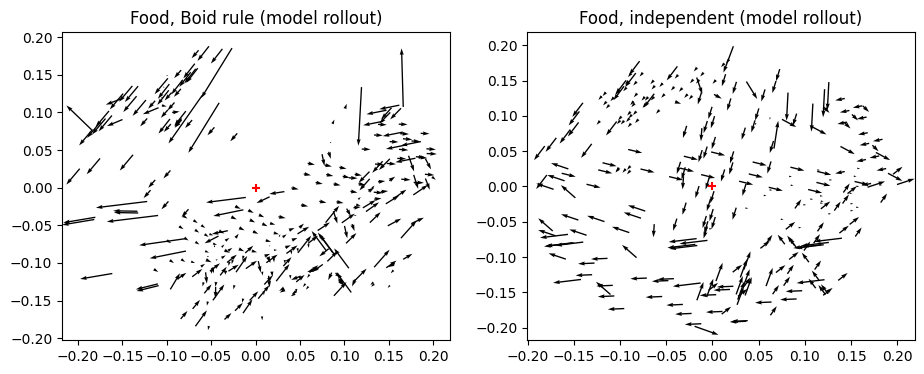

In [84]:
fig, axes = plt.subplots(1, 2, figsize = (11, 4))

axes[0].scatter(0,0,marker = '+',c = 'r')
axes[0].quiver(del_pos_model[:,0],del_pos_model[:,1],
            vnext_model[:,0]*10,vnext_model[:,1]*10)


axes[1].scatter(0,0,marker = '+',c = 'r')
axes[1].quiver(del_pos_model2[:,0],del_pos_model2[:,1],
            vnext_model2[:,0]*10,vnext_model2[:,1]*10)

axes[0].set_title("Food, Boid rule (model rollout)")
axes[1].set_title("Food, independent (model rollout)")

In [ ]:
# - subsample: every 1/10: repulsion

# - make more files to do rollout. restrict to 50 